# 🔍 Customer Churn Prediction - Proyecto ML

**Paso 1: Entendiendo el problema**

El abandono de clientes (customer churn) es un gran problema para las empresas que ofrecen servicios por suscripción. Este proyecto busca predecir si un cliente se va a dar de baja o no, utilizando datos históricos de sus características y comportamiento.

---

- **Tipo de problema**: Clasificación binaria
- **Dataset**: Público, obtenido de Kaggle  
  URL: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset
- **Objetivo**: Construir un modelo que prediga la variable `churn` (abandono del cliente)



In [54]:
# Librerías

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib
import os


**Paso 2: Carga de datos**

In [28]:
# Ruta a los archivos
train_path = "../data_sample/customer_churn_dataset-training-master.csv"
test_path = "../data_sample/customer_churn_dataset-testing-master.csv"

# Cargar datasets
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Mostrar forma y primeras filas
print(df_train.shape)
print(df_test.shape)
df_train.head()


(440833, 12)
(64374, 12)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


**Paso 3: Análisis Exploratorio de Datos (EDA)**

In [29]:
print("Columnas disponibles:")
print(df_train.columns)

Columnas disponibles:
Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')


In [30]:

# Ver dimensiones
print("Shape del dataset de entrenamiento:", df_train.shape)

# Ver tipos de datos
print("\nTipos de datos:")
print(df_train.dtypes)

# Ver valores nulos
print("\nValores nulos por columna:")
print(df_train.isnull().sum())

# Ver distribución de la variable objetivo
print("\nDistribución de la variable 'churn':")
print(df_train['Churn'].value_counts())

Shape del dataset de entrenamiento: (440833, 12)

Tipos de datos:
CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                float64
dtype: object

Valores nulos por columna:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Distribución de la variable 'churn':
Churn
1.0    249999
0.0    190833
Name: count, dtype: int64


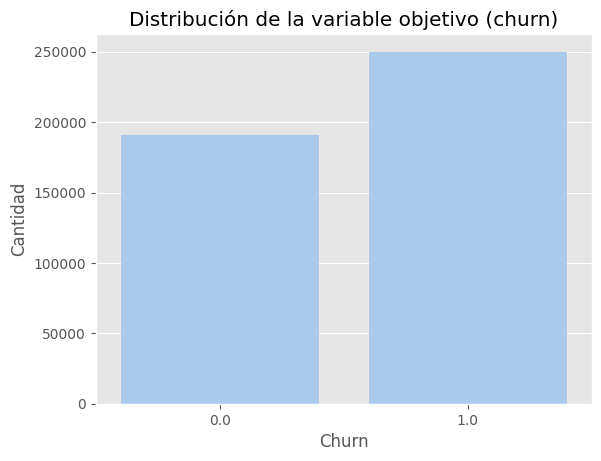

In [31]:
# Gráfico de barras para la variable objetivo
sns.countplot(x='Churn', data=df_train)
plt.title('Distribución de la variable objetivo (churn)')
plt.xlabel('Churn')
plt.ylabel('Cantidad')
plt.show()


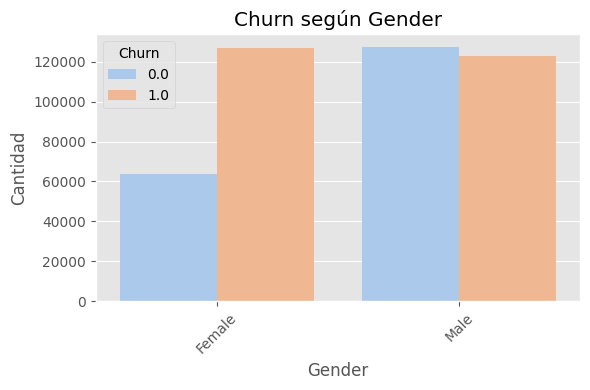

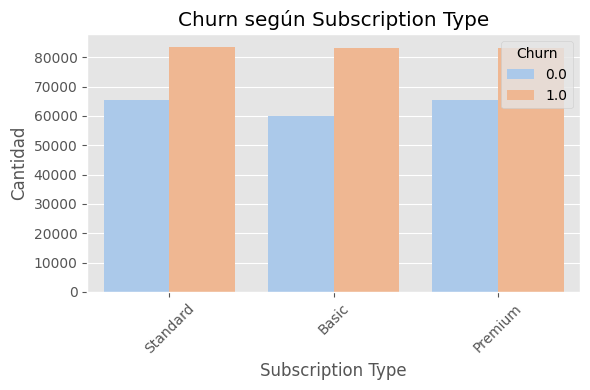

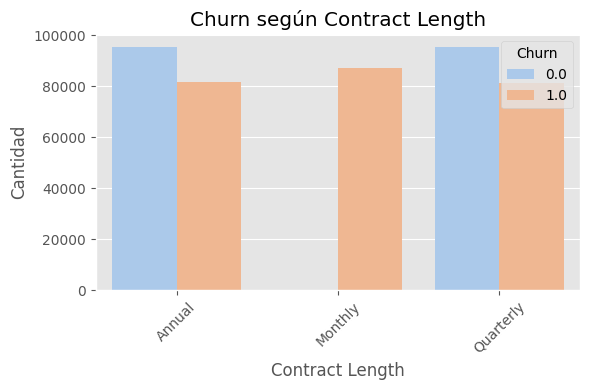

In [32]:
# Análisis de variables categóricas vs. Churn

# Función para graficar Churn vs variables categóricas
def plot_churn_vs_column(col):
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Churn', data=df_train)
    plt.title(f'Churn según {col}')
    plt.legend(title='Churn')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_churn_vs_column('Gender')
plot_churn_vs_column('Subscription Type')
plot_churn_vs_column('Contract Length')


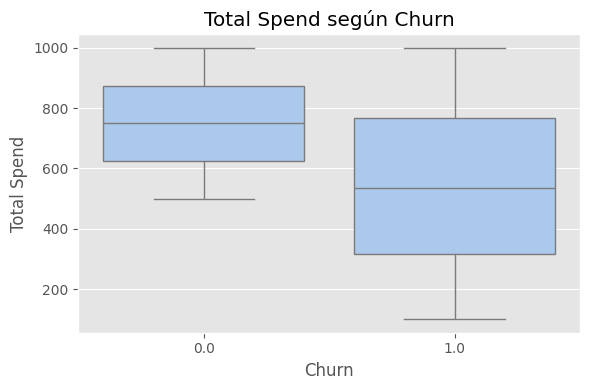

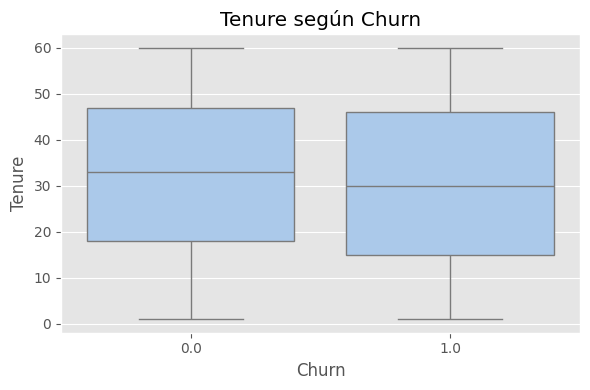

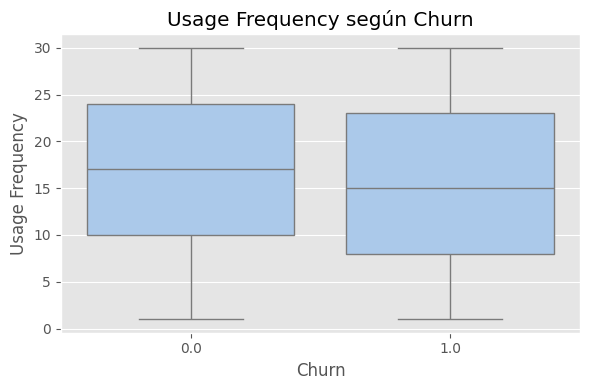

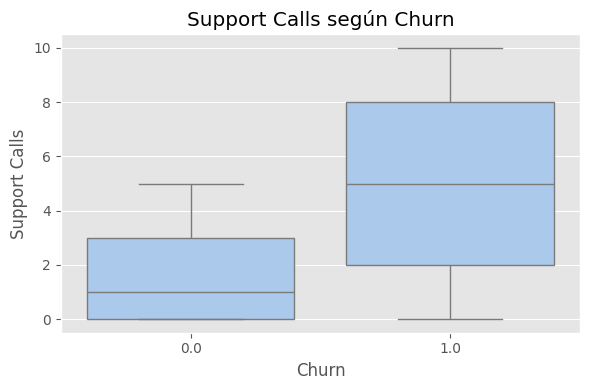

In [33]:
# Análisis de variables numéricas vs. Churn


def plot_numeric_vs_churn(col):
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df_train)
    plt.title(f'{col} según Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


numericas = ['Total Spend', 'Tenure', 'Usage Frequency', 'Support Calls']
for var in numericas:
    plot_numeric_vs_churn(var)


### ✅ Conclusiones del Análisis Exploratorio (EDA)

- La variable objetivo `Churn` está **moderadamente desbalanceada**, con más clientes que abandonan que los que se quedan.
- Variables categóricas como **`Subscription Type` y `Contract Length`** muestran patrones claros con el churn.
- **Los contratos mensuales** y las **suscripciones básicas** tienen mayor tasa de abandono.
- En cuanto a variables numéricas:
  - Los clientes que **gastan menos (`Total Spend`)** o **llaman más al soporte (`Support Calls`)** tienden a abandonar más.
  - La variable **`Tenure`** también muestra una ligera relación: clientes antiguos se quedan más.
  - `Usage Frequency` no muestra diferencias claras.
- Estas observaciones nos ayudarán a seleccionar y preparar variables para entrenar el modelo de clasificación.


**Paso 4: Limpieza de datos**

In [34]:
# Verificar valores nulos antes de limpiar
print("Valores nulos antes de limpiar:")
print(df_train.isnull().sum())

# Eliminar filas con valores nulos
df_train = df_train.dropna()
df_test = df_test.dropna()

# Asegurar que la variable objetivo sea tipo entero
df_train['Churn'] = df_train['Churn'].astype(int)
df_test['Churn'] = df_test['Churn'].astype(int)

# Verificación después de la limpieza
print("\nValores nulos después de limpiar:", df_train.isnull().sum().sum())
print("Tipos de datos finales:\n", df_train.dtypes)


Valores nulos antes de limpiar:
CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Valores nulos después de limpiar: 0
Tipos de datos finales:
 CustomerID           float64
Age                  float64
Gender                object
Tenure               float64
Usage Frequency      float64
Support Calls        float64
Payment Delay        float64
Subscription Type     object
Contract Length       object
Total Spend          float64
Last Interaction     float64
Churn                  int32
dtype: object


**Paso 5: Preparación de los datos para el modelado**

In [36]:
# Eliminamos columnas que no nos sirven para predecir, como CustomerID
X = df_train.drop(['CustomerID', 'Churn'], axis=1)
y = df_train['Churn']

In [ ]:
# One-Hot Encoding para convertir en numéricas
X = pd.get_dummies(X, columns=['Gender', 'Subscription Type', 'Contract Length'], drop_first=True)

In [38]:
# Train/Test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
# Escalamos
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)

**Paso 6: Entrenamiento del modelo con XGBoost**

## Modelo XGBoost
Se elige XGBoost como modelo principal de Machine Learning porque es uno de los algoritmos más potentes y utilizados en problemas de clasificación con datos tabulares. Es capaz de manejar tanto variables numéricas como categóricas (una vez codificadas), es robusto frente a datos desbalanceados, y suele obtener mejores resultados que otros modelos tradicionales. Además, permite interpretar la importancia de las variables, lo cual es útil para entender qué factores influyen más en el abandono de clientes.

In [42]:
# Modelo con parámetros básicos
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [43]:
# Entrenamos el modelo con nuestros datos escalados
xgb_model.fit(X_train_scaled, y_train)

c:\Users\iagog\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:35:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [44]:
# Predicción sobre churn
y_pred_xgb = xgb_model.predict(X_val_scaled)


In [46]:
# Accuracy 
acc_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy con XGBoost: {acc_xgb:.4f}")

Accuracy con XGBoost: 0.9999


In [47]:
# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_val, y_pred_xgb))


Matriz de confusión:
[[38167     0]
 [    7 49993]]


In [48]:

# Precisión, recall, F1-score
print("\nReporte de clasificación:")
print(classification_report(y_val, y_pred_xgb))


Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38167
           1       1.00      1.00      1.00     50000

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



### ⚠️ Resultados sospechosos

Este modelo  muestra métricas métricas excesivamente perfectas (accuracy de 99.9%, f1-score de 1.00), lo cual no es habitual en un problema real como la predicción de abandono de clientes. Esto indica una posible **fuga de información**, es decir, que el modelo estaba accediendo a variables que contenían pistas del futuro o directamente del resultado por lo que es necesario estudiar la importancia que tienen distintas variables en el modelo. Variables como "Total Spend", "Payment Delay", "Last Interaction" pueden estar en los primeros puestos, lo que indica posibilidad de estar relacionadas directamente con el hecho de que el cliente se fue.


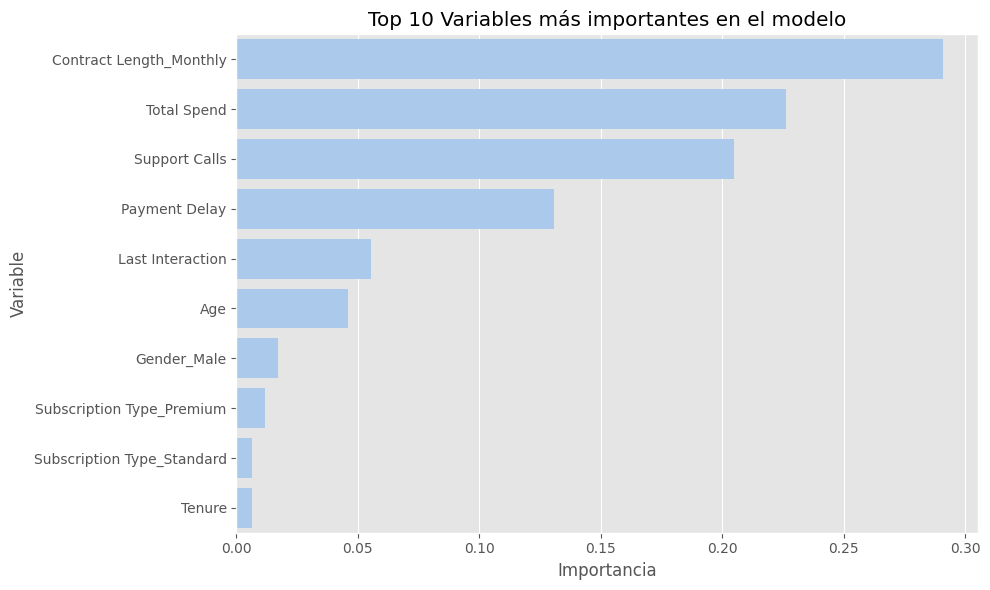

,Feature,Importance
10,Contract Length_Monthly,0.290844
5,Total Spend,0.226135
3,Support Calls,0.204771
4,Payment Delay,0.130760
6,Last Interaction,0.055545
0,Age,0.046028
7,Gender_Male,0.017044
8,Subscription Type_Premium,0.011828
9,Subscription Type_Standard,0.006602
1,Tenure,0.006353


In [49]:
# Extraer importancia de cada variable
importances = xgb_model.feature_importances_
features = X_train.columns

# Crear un DataFrame ordenado por importancia
feat_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_importance = feat_importance.sort_values(by='Importance', ascending=False)

# Mostrar top 10 variables
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_importance.head(10))
plt.title("Top 10 Variables más importantes en el modelo")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# Mostrar tabla completa si quieres
feat_importance.head(20)

In [52]:
# Lista de columnas que podrían estar causando fuga de información
cols_fuga = ['Total Spend', 'Payment Delay', 'Last Interaction']

# Creamos una nueva copia del dataset sin esas columnas
X_clean = X.drop(cols_fuga, axis=1)

# Mantenemos la misma y
y_clean = y.copy()

# Dividimos de nuevo en train y validación
X_train_clean, X_val_clean, y_train_clean, y_val_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

# Escalado
scaler_clean = StandardScaler()
X_train_clean_scaled = scaler_clean.fit_transform(X_train_clean)
X_val_clean_scaled = scaler_clean.transform(X_val_clean)


In [53]:

# Nuevo modelo
xgb_clean = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clean.fit(X_train_clean_scaled, y_train_clean)

# Predicciones
y_pred_clean = xgb_clean.predict(X_val_clean_scaled)

# Evaluación
print("Accuracy sin variables sospechosas:", accuracy_score(y_val_clean, y_pred_clean))
print("\nMatriz de confusión:")
print(confusion_matrix(y_val_clean, y_pred_clean))
print("\nReporte de clasificación:")
print(classification_report(y_val_clean, y_pred_clean))


c:\Users\iagog\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy sin variables sospechosas: 0.9347374868147946

Matriz de confusión:
[[38165     2]
 [ 5752 44248]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     38167
           1       1.00      0.88      0.94     50000

    accuracy                           0.93     88167
   macro avg       0.93      0.94      0.93     88167
weighted avg       0.94      0.93      0.94     88167



### ✅ Corrección de fuga y mejora del modelo

Para evitar la fuga de información, se identificaron y eliminaron tres variables del conjunto de datos: `Total Spend`, `Payment Delay` y `Last Interaction`, ya que contenían información que podía reflejar el comportamiento del cliente después del abandono. 

Se reentrenó el modelo con XGBoost sin esas variables y se obtuvo un accuracy más realista (93.5%) y métricas equilibradas. Esto confirma que el nuevo modelo es más fiable y generalizable.


**Paso 6: Guardado del modelo entrenado**

Una vez entrenado el modelo final de XGBoost sin variables con fuga, se guarda junto al escalador para su reutilización futura. Esto permite cargar el modelo sin necesidad de volver a entrenarlo.


In [ ]:

# Ruta a la carpeta 'models' desde el directorio 'notebooks'
models_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), '..')), 'src', 'models')

# Asegurarse de que la carpeta 'models' exista
os.makedirs(models_path, exist_ok=True)

# Guardar el modelo XGBoost en la carpeta correcta
joblib.dump(xgb_clean, os.path.join(models_path, 'xgb_churn_model.joblib'))

# Guardar el escalador en la misma carpeta
joblib.dump(scaler_clean, os.path.join(models_path, 'scaler.joblib'))

['c:\\Users\\iagog\\Desktop\\ML_customer_churn\\src\\src\\models\\scaler.joblib']